In [27]:
%matplotlib inline

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from clpsych.store import Store
from clpsych.helpers import load_tokens

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import codecs

In [2]:
def read_liwc(path='./data/other_materials/liwc/LIWC2007.dic'):
    reading_words = []
    categories, words = {}, {}
    with codecs.open(path, 'r') as fp:
        # skip the very first '%'
        fp.readline()
        # read the data (first the categories and their indices, then the words)
        for line in fp:
            if line.strip() == '%':
                reading_words = True
            
            if reading_words:
                l = line.strip().split('\t')
                try:
                    word, cats = l[0], [int(v) for v in l[1:]]
                    # clear out the asterisk if there is one
                    if word[-1] == '*':
                        word = word[:-1]
                except ValueError:
                    continue
                # add it to the dict
                words[word] = cats
            else:
                ix, cat = line.strip().split()
                categories[int(ix)] = cat
    return categories, words

def process_text_with_liwc(text, words, subcats=[]):
    topics = []
    for token in text:
        token_topics = words.get(token, [])
        topics.extend(token_topics)
    if len(subcats) > 0:
        topics = [t for t in topics if t in subcats]
    return topics

In [3]:
categories, words = read_liwc()

In [4]:
train_classes = pd.DataFrame.from_csv('data/classes/train_classes.txt')
dev_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')
sample_classes = pd.DataFrame.from_csv('data/classes/sample_classes.txt')

In [6]:
df = load_tokens('./data/tokens/lemmas.txt')
df.replace(np.nan, '', regex=True)
df['text_features'] = df[['title', 'doc']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [7]:
df['topics'] = df.text_features.astype(str).str.split().apply(lambda x: process_text_with_liwc(x, words))

In [8]:
vect = CountVectorizer(lowercase=False, tokenizer=lambda x: x)

In [9]:
X = vect.fit_transform(df['topics'])

In [10]:
vectorized = pd.DataFrame(X.todense(), columns=vect.get_feature_names())

In [11]:
df = pd.concat([df, vectorized], axis=1)

In [13]:
for col in ['title', 'doc', 'topics']:
    df = df.drop(col, 1)

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
sent1 = pd.DataFrame.from_csv('data/features/sentiment_all.csv')
read1 = pd.DataFrame.from_csv('data/features/readability1.csv')
read2 = pd.DataFrame.from_csv('data/features/readability2.csv')
times = pd.DataFrame.from_csv('data/features/timing.csv')

df = df\
    .merge(sent1[['post_id', 'text_sentiment', 'title_sentiment']], on='post_id')\
    .merge(read1[['post_id', 'text_smog', 'text_readability', 'title_readability']], on='post_id')\
    .merge(read2[['post_id', 'title_smog']], on='post_id')\
    .merge(times[['post_id', 'night_post', 'time_since_last_post']])

#X_train = df.merge(train_classes, on='post_id').drop('text_features', 1).drop('post_id', 1).drop('class', 1).as_matrix()
#X_test = df.merge(dev_classes, on='post_id').drop('text_features', 1).drop('post_id', 1).drop('class', 1).as_matrix()

In [83]:
X_test.shape

(207206, 72)

In [84]:
X_train.shape

(1721484, 72)

In [85]:
y_train = df_final.merge(train_classes, on='post_id')['class'].as_matrix()
y_test = df_final.merge(dev_classes, on='post_id')['class'].as_matrix()

In [114]:
X_train[np.isnan(X_train)] = 100000.
X_test[np.isnan(X_test)] = 100000.

In [128]:
clf = RandomForestClassifier(n_estimators=50, max_depth=30, n_jobs=6)

In [129]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=6, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Accuracy: 0.737637906238
AUC: 0.667944717438
F1 Score: 0.844640300414


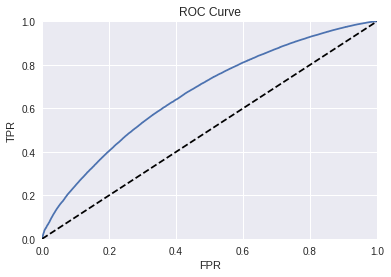

In [144]:
labels = clf.predict_proba(X_test)

print 'Accuracy:', accuracy_score(y_test, np.argmax(labels, axis=1))

fpr, tpr, thresholds = roc_curve(y_test, labels[:, 1])

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')

print 'AUC:', roc_auc_score(y_test, labels[:, 1])
print 'F1 Score:', f1_score(y_test, np.argmax(labels, axis=1))